---
# Simulate ISIs for experiment

The goal of this notebook is to find a strategy in which we find an optimal set of inter-stimulus intervals for the Hole-Response experiment. Here, we've simulated the response of a target pRF to full-field stimulus minus a mask to maximize suppression, as well as to growing stimuli to find a stimulus that maximizes a positive response. Here, we'll use the stimulus sizes for both to recreate a design matrix which we'll feed into the pRF estimates of the target

In [1]:
from linescanning import (
    prf,
    utils,
    plotting,
    glm,
    simulate
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
import os
import seaborn as sns
opj = os.path.join

In [2]:
subject = "sub-005"
hemi = "L"
proj_dir = os.environ.get("DIR_DATA_HOME")
prf_file = opj(
    proj_dir, 
    "derivatives", 
    "pycortex", 
    subject, 
    f"{subject}_model-norm_desc-best_vertices.csv")

pars = pd.read_csv(prf_file).set_index(["hemi"])
pars

,Unnamed: 0,x,y,prf_size,prf_ampl,bold_bsl,surr_ampl,surr_size,neur_bsl,surr_bsl,...,r2,size ratio,suppression index,ecc,polar,index,position,normal,stim_sizes,stim_betas
hemi,,,,,,,,,,,,,,,,,,,,,
L,0,1.769237,-0.938022,0.751352,137.975401,0.0,3.470721,18.009438,137.968613,100.026629,...,0.702819,23.969382,14.452124,2.002519,-0.487503,7880,[-16.478348 -82.42885 -21.242748],[ 0.38899298 -0.80831088 -0.44194795],[1.76258451 6.1690458 ],[-1.37045859 18.32740001]
R,1,-2.412908,0.386792,0.871731,19.396739,0.0,0.374584,4.939297,193.742218,100.008472,...,0.775111,5.666077,0.619991,2.443713,2.982644,318247,[ 1.8937228 -79.74463 -14.561625 ],[ 0.46387144 0.62267742 -0.63015562],[3.02157345 5.79134912],[-1.70826381 9.83209416]


---
# Simulate with GLM

In [3]:
# fetch stimulus betas
stim_betas = utils.string2float(pars["stim_betas"][hemi])
stim_betas

array([-1.37045859, 18.32740001])

In [4]:
# settings
settings_path = "/data1/projects/MicroFunc/Jurjen/programs/project_repos/LineExps/ActNorm/settings.yml"
with open(settings_path, 'r', encoding='utf8') as f_in:
    settings = yaml.safe_load(f_in)

TR = 0.105
osf = 1000
n_trials = settings['design'].get('n_trials')
stim_duration = settings['design'].get('stim_duration')
start_duration = settings['design'].get('start_duration')
end_duration = settings['design'].get('end_duration')
theor_total_duration = 585 #s -> 6 minutes 
hrf_diff = 0.08

# define HRF
dt = 1/osf
time_points = np.linspace(0, 25, np.rint(float(25)/dt).astype(int))
hrf_0 = glm.double_gamma(time_points, lag=5)
hrf_100ms = glm.double_gamma(time_points, lag=(5-hrf_diff))

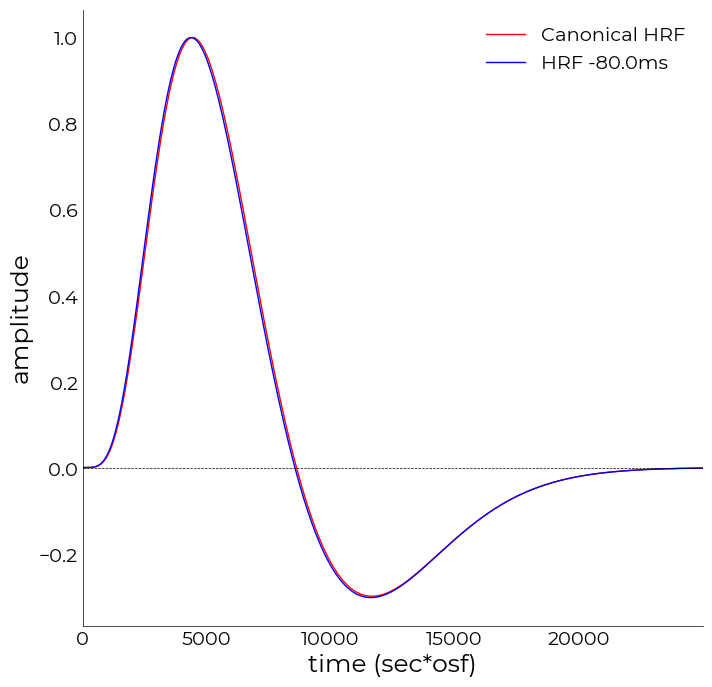

In [5]:
%matplotlib inline
plotting.LazyPlot(
    [hrf_0,hrf_100ms],
    figsize=(8,8),
    x_label="time (sec*osf)",
    y_label="amplitude",
    labels=["Canonical HRF",f"HRF -{hrf_diff*1000}ms"],
    color=["r","b"],
    line_width=1,
    add_hline=0)

In [12]:
n_iters = 1000
events=["act","norm"]
n_events = len(events)
presented_stims = np.r_[[np.full(n_trials//n_events, ii, dtype=int) for ii in range(n_events)]].flatten()

np.random.seed(1123)
np.random.shuffle(presented_stims)

# LUT variance
# 0 = var_act
# 1 = var_suppr
# 2 = var_diff for activation predictor
# 3 = var_diff for suppression predictor

df_isis = []
df_var = []
for it in range(n_iters):

    df_variance = {}
    for el in ["variance","code", "name"]:
        df_variance[el] = []

    iti_obj = simulate.ITI(
        tmin=settings['design'].get('minimal_iti_duration'),
        tmax=settings['design'].get('maximal_iti_duration'),
        tmean=settings['design'].get('mean_iti_duration'),
        n_trials=n_trials,
        leeway=settings['design'].get('total_iti_duration_leeway'),
        stim_duration=stim_duration,
        total_duration=theor_total_duration,
        start_duration=start_duration,
        end_duration=end_duration,
        verbose=False,
        events=events,
        seq=presented_stims
    )

    func_vols = round(iti_obj.total_experiment_time/TR)

    # make stimulus vector
    stims = glm.make_stimulus_vector(
        iti_obj.get_onsets(), 
        scan_length=func_vols, 
        osf=osf, 
        type='block', 
        block_length=stim_duration)

    # convolve with HRF
    stim_vector = glm.convolve_hrf([hrf_0,hrf_100ms], stims)

    # resample to functional time domain
    stim_vector_resampled = glm.resample_stim_vector(stim_vector, func_vols)

    # get predictions by multiplying response magnitude to optimal stimulus (beta) with convolved stimulus vector
    pred_act    = [stim_vector_resampled["act"][:,ii]*stim_betas[1] for ii in range(len([hrf_0,hrf_100ms]))]
    pred_suppr  = [stim_vector_resampled["norm"][:,ii]*stim_betas[0] for ii in range(len([hrf_0,hrf_100ms]))]

    # get variances
    var_act         = np.var(pred_act[0])
    var_suppr       = np.var(pred_suppr[0])
    var_act_diff    = np.var(np.abs(pred_act[1]-pred_act[0]))
    var_suppr_diff  = np.var(np.abs(pred_suppr[1]-pred_suppr[0]))

    # append
    for ix,(var,nn) in enumerate(zip(
        [var_act,var_suppr,var_act_diff,var_suppr_diff],
        ["act","suppr","act_diff","suppr_diff"]
        )):

        df_variance["variance"].append(var)
        df_variance["code"].append(ix)
        df_variance["name"].append(nn)
        
    df_variance = pd.DataFrame(df_variance)
    df_variance["it"] = it
    df_variance["isi_obj"] = iti_obj
    df_var.append(df_variance)

    # # keep track of ISIs
    # df_isi = pd.DataFrame(iti_obj.itis, columns=[f"iter-{it}"])
    # df_isis.append(df_isi)

df_var = pd.concat(df_var)
df_var.to_pickle("/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/data/simulate.pkl")
# df_isis = pd.concat(df_isis, axis=1)
# df_isis["events"] = np.array([events[i] for i in presented_stims])

In [104]:
df_var.to_pickle("test.pkl")

In [107]:
df_var2 = pd.read_pickle("test.pkl")
df_var2["isi_obj"].iloc[0].get_onsets()

onset  duration
subject run event_type                      
1       1   act          44.263077       2.0
            act          49.367480       2.0
            act          57.264199       2.0
            act          63.102681       2.0
            act          72.751394       2.0
...                            ...       ...
            norm        522.488239       2.0
            norm        528.966504       2.0
            norm        537.539618       2.0
            norm        542.855920       2.0
            norm        550.362347       2.0

[64 rows x 2 columns]

In [52]:
utils.select_from_df(df_var, expression=f"code = {ix}")

,index,variance,code,name,it
0,0,1.030236e+08,0,act,0
4,0,1.042452e+08,0,act,1
8,0,1.129599e+08,0,act,2
12,0,1.010606e+08,0,act,3
16,0,1.107281e+08,0,act,4
20,0,9.265603e+07,0,act,5
24,0,1.052238e+08,0,act,6
28,0,1.120204e+08,0,act,7
32,0,1.145077e+08,0,act,8
36,0,1.061573e+08,0,act,9


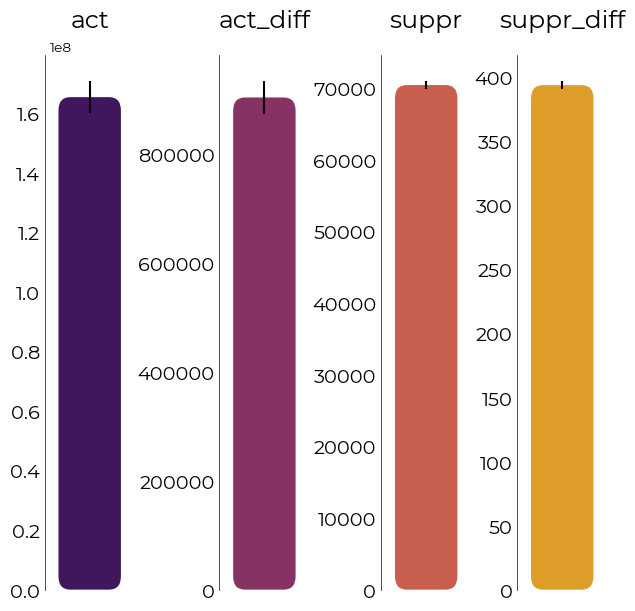

In [22]:
cols = sns.color_palette("inferno", 4)
fig,axs = plt.subplots(ncols=4, figsize=(6,6), constrained_layout=True)

for ix,el in enumerate(list(np.unique(df_var["name"].values))):

    ax = axs[ix]
    plotting.LazyBar(
        utils.select_from_df(df_var, expression=f"code = {ix}"),
        x="code",
        y="variance",
        axs=ax,
        title2=el,
        sns_ori="v",
        fancy=True,
        color=cols[ix],
        sns_offset=4,
        fancy_denom=6,
        error="std"
    )

In [99]:
utils.select_from_df(df_var, expression=f"it = 9")["isi_obj"].iloc[0].itis

array([ 7.50785613,  4.17296506,  5.17874211,  3.29861951, 18.        ,
        5.33149522,  3.9568022 ,  8.23179623,  3.37893152,  5.09950736,
        5.98596824, 11.16030472,  7.758273  ,  3.50042482,  4.30462303,
        5.87865538,  7.48564387,  3.04783037,  6.43959699,  8.02957476,
        8.27367633,  4.87629927,  4.2713265 ,  3.96353011,  5.39754176,
        3.10850162,  8.02613397,  4.28362571,  4.69894372,  6.22648335,
       10.93779441,  9.44856113,  5.7022815 ,  9.86730433,  4.38587654,
        4.35790804,  4.51909568,  3.98662862,  6.07272994,  4.26763684,
        3.35247357,  8.29643892,  7.29750001,  5.08392473,  5.46184689,
        4.72435762,  6.75941352,  3.44539838,  7.8761295 ,  6.8601237 ,
        7.24060169,  5.5131223 ,  6.24520894,  4.51293235,  6.96691316,
        3.90186941,  5.22872345,  4.81104825,  6.78381726,  7.98121878,
        4.6850164 ,  3.51080142,  9.16161947,  3.79321889])

Iteration 594 maximizes 'act'
Iteration 66 maximizes 'act_diff'
Iteration 451 maximizes 'suppr'
Iteration 260 maximizes 'suppr_diff'


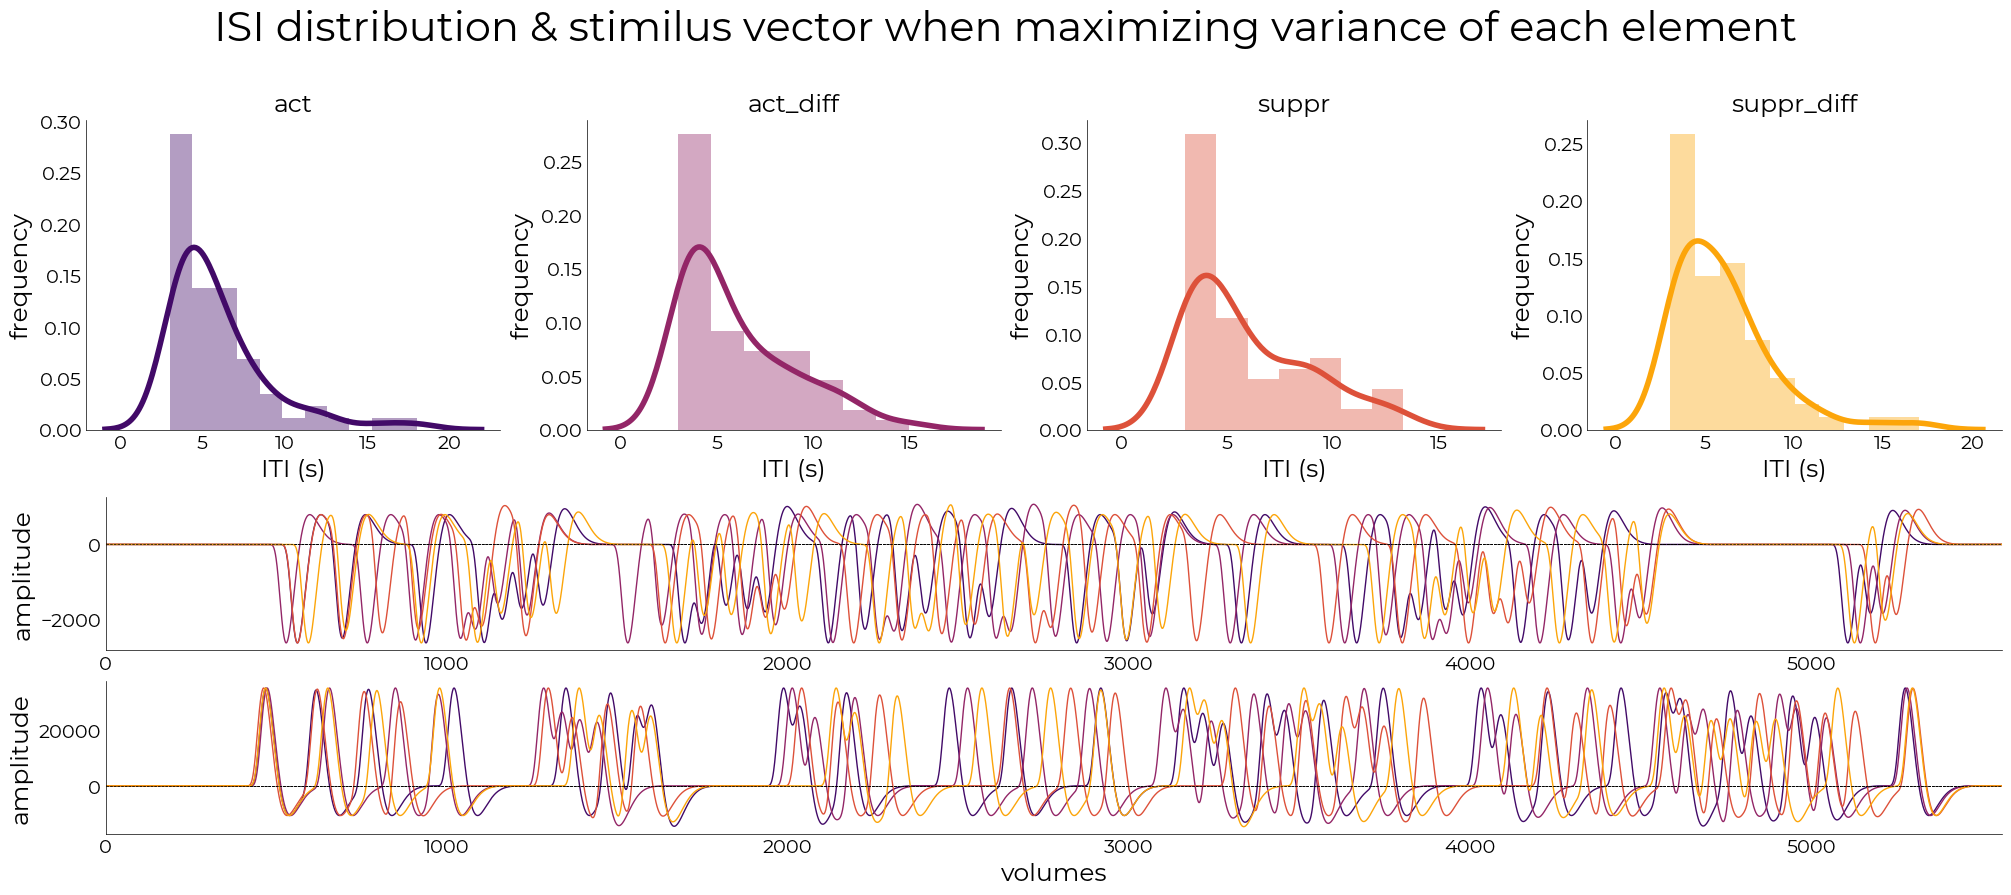

In [29]:
fig = plt.figure(figsize=(20,8), constrained_layout=True)
sf = fig.subfigures(nrows=2)
sf1 = sf[0].subplots(ncols=4)
sf2 = sf[1].subplots(nrows=2)

for ix,el in enumerate(list(np.unique(df_var["name"].values))):

    # get max variance for all elements
    max_var = utils.select_from_df(df_var, expression=f"code = {ix}")
    max_var_ix = max_var.loc[max_var["variance"].idxmax()].it
    print(f"Iteration {max_var_ix} maximizes '{el}'")

    # get corresponding set of ITIs
    max_var_isi_obj = utils.select_from_df(df_var, expression=f"it = {max_var_ix}")["isi_obj"].iloc[0]
    max_var_isis = max_var_isi_obj.itis

    # plot distribution
    ax = sf1[ix]
    plotting.LazyHist(
        max_var_isis,
        axs=ax,
        kde=True,
        hist=True,
        fill=False,
        title=el,
        y_label2="frequency",
        x_label2="ITI (s)",
        color=cols[ix],
        hist_kwargs={"alpha": 0.4},
        kde_kwargs={"linewidth": 4}
    )

    func_vols = round(iti_obj.total_experiment_time/TR)

    # make stimulus vector
    stims = glm.make_stimulus_vector(
        max_var_isi_obj.get_onsets(), 
        scan_length=func_vols, 
        osf=osf, 
        type='block',
        block_length=stim_duration)

    # convolve with HRF
    stim_vector = glm.convolve_hrf([hrf_0], stims)

    # resample to functional time domain
    stim_vector_resampled = glm.resample_stim_vector(stim_vector, func_vols)
    stim_vector_resampled
    
    input_data = stim_vector_resampled["norm"][:,0]*stim_betas[0]
    if ix == 0:
        set_title = "suppression vector"
        y_label = "amplitude"
    else:
        set_title = None
        y_label = None

    plotting.LazyPlot(
        input_data,
        axs=sf2[0],
        line_width=1,
        add_hline=0,
        color=cols[ix],
        y_label=y_label,
        title=set_title)

    input_data = stim_vector_resampled["act"][:,0]*stim_betas[1]
    if ix == 0:
        x_label = "volumes"
        set_title = "activation vector"
        y_label = "amplitude"
    else:
        x_label = None
        set_title = None
        y_label = None

    plotting.LazyPlot(
        input_data,
        axs=sf2[1],
        line_width=1,
        add_hline=0,
        color=cols[ix],
        y_label=y_label,
        x_label=x_label,
        title=set_title
    )

fig.suptitle("ISI distribution & stimilus vector when maximizing variance of each element", fontsize=30, y=1.1)
fname = "/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/data/simulate.pdf"
fig.savefig(
    fname,
    bbox_inches="tight",
    dpi=300,
    facecolor="white"
)

In [26]:
events=["act","norm"]
n_events = len(events)
presented_stims = np.r_[[np.full(n_trials//n_events, ii, dtype=int) for ii in range(n_events)]].flatten()

iti_obj = simulate.ITI(
    tmin=settings['design'].get('minimal_iti_duration'),
    tmax=settings['design'].get('maximal_iti_duration'),
    tmean=settings['design'].get('mean_iti_duration'),
    n_trials=n_trials,
    leeway=settings['design'].get('total_iti_duration_leeway'),
    stim_duration=stim_duration,
    total_duration=theor_total_duration,
    start_duration=start_duration,
    end_duration=end_duration,
    verbose=True,
    events=events,
    seq=presented_stims
)

# iti_obj.plot_iti_distribution()

ITIs created with total ITI duration of 385.79s after 19 iterations
Total experiment time: 583.79s (= 5560 samples)


In [27]:
func_vols = round(iti_obj.total_experiment_time/TR)

# make stimulus vector
stims = glm.make_stimulus_vector(iti_obj.get_onsets(), scan_length=func_vols, osf=osf, type='block', block_length=stim_duration)

# convolve with HRF
stim_vector = glm.convolve_hrf([hrf_0,hrf_100ms], stims)

# resample to functional time domain
stim_vector_resampled = glm.resample_stim_vector(stim_vector, func_vols)
stim_vector_resampled
# # get variance
# arr_vars[it] = np.var(stim_vector_resampled)

{'act': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 'norm': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])}

In [28]:
dm = glm.first_level_matrix(stim_vector_resampled)
dm

,intercept,act,act_1st_derivative,norm,norm_1st_derivative
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
5555,1.0,0.0,0.0,0.0,0.0
5556,1.0,0.0,0.0,0.0,0.0
5557,1.0,0.0,0.0,0.0,0.0
5558,1.0,0.0,0.0,0.0,0.0


Diff: 1300.7585535171675


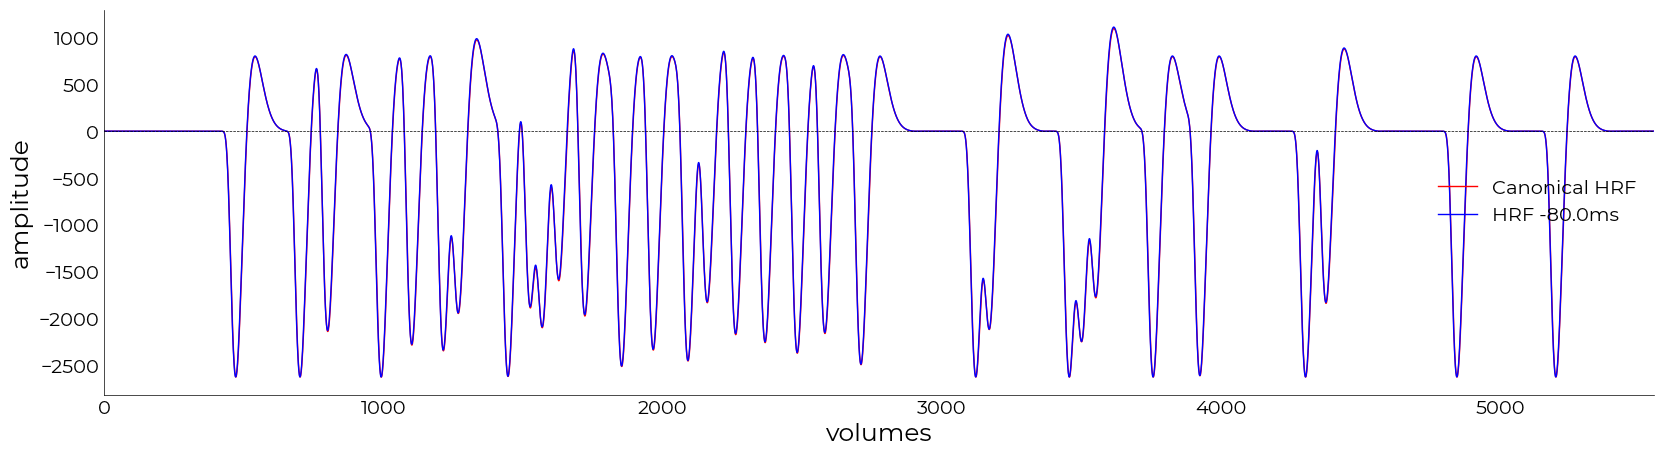

In [31]:
input_data = [stim_vector_resampled["norm"][:,ii]*stim_betas[0] for ii in range(len([hrf_0,hrf_100ms]))]
variance = np.array([np.var(stim_vector_resampled["norm"][:,ii]*stim_betas[0]) for ii in range(len([hrf_0,hrf_100ms]))])

plotting.LazyPlot(
    input_data,
    figsize=(20,5),
    line_width=1,
    x_label="volumes",
    y_label="amplitude",
    add_hline=0,
    color=["r","b"],
    labels=["Canonical HRF",f"HRF -{hrf_diff*1000}ms"],
)

variance_diff = np.abs(variance[1]-variance[0])
print(f"Diff: {variance_diff}")

In [30]:
np.abs(*listvariance)

TypeError: return arrays must be of ArrayType

---
# Simulate as pRF experiment

In [3]:
# set screen information
screen_distance_cm = 196
screen_size_cm_x = 69.8
screen_size_cm_y = 38.9

# define visual field in degree of visual angle
ss_deg_x = 2*np.degrees(np.arctan(screen_size_cm_x/(2.0*screen_distance_cm)))
x = np.linspace(-ss_deg_x/2, ss_deg_x/2, 1920)

ss_deg_y = 2*np.degrees(np.arctan(screen_size_cm_y/(2.0*screen_distance_cm)))
y = np.linspace(-ss_deg_y/2, ss_deg_y/2, 1080)

# define visual extent:
x_ext = [-ss_deg_x/2,ss_deg_x/2]
y_ext = [-ss_deg_y/2,ss_deg_y/2]
vf_extent = (x_ext,y_ext)
vf_extent

([-10.096339969824111, 10.096339969824111],
 [-5.667175191697089, 5.667175191697089])

In [4]:
# make stimuli
stims_full, sizes_full = prf.make_stims(
    (x,y), 
    factor=2, 
    dt="fill")

stims_hole, sizes_hole = prf.make_stims(
    (x,y), 
    factor=2, 
    dt="hole")

In [5]:
# fetch stimulus sizes
stim_sizes = utils.string2float(pars["stim_sizes"][hemi])
stim_sizes

array([2.03045664, 5.63796698])

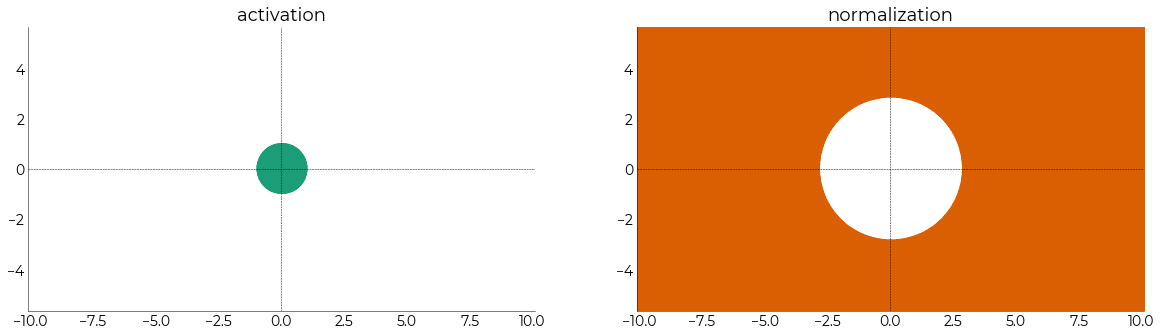

In [7]:
%matplotlib inline
# plot
cols = ["#1B9E77","#D95F02"]


fig,axs = plt.subplots(ncols=2, figsize=(20,6))
stims = []
for x,(ii,stim,nn) in enumerate(zip(stim_sizes, [sizes_full,sizes_hole],["activation","normalization"])):
    
    ix = utils.find_nearest(stim, ii)[0]
    img = stims_full[ix]
    cmap = utils.make_binary_cm(cols[x])

    if nn == "normalization":
        tmp = np.ones_like(img)
        tmp[img>0] = 0
        img = tmp.copy()
        
    axs[x].imshow(img, cmap=cmap, extent=vf_extent[0]+vf_extent[1])
    axs[x].axvline(0, color='k', linestyle='dashed', lw=0.5)
    axs[x].axhline(0, color='k', linestyle='dashed', lw=0.5)
    axs[x].set_title(nn)
    
    plotting.conform_ax_to_obj(ax=axs[x])
    stims.append(img)
    # axs.axis('off')

In [8]:
# settings
settings_path = "/data1/projects/MicroFunc/Jurjen/programs/project_repos/LineExps/ActNorm/settings.yml"
with open(settings_path, 'r', encoding='utf8') as f_in:
    settings = yaml.safe_load(f_in)

TR = 0.105
osf = 1000
n_trials        = settings['design'].get('n_trials')
stim_duration   = settings['design'].get('stim_duration')
start_duration  = settings['design'].get('start_duration')
end_duration    = settings['design'].get('end_duration')
theor_total_duration = 420 #s -> 7 minutes 
print(n_trials)

32


In [41]:
iti_obj = simulate.ITI(
    tmin=settings['design'].get('minimal_iti_duration'),
    tmax=settings['design'].get('maximal_iti_duration'),
    tmean=settings['design'].get('mean_iti_duration'),
    n_trials=n_trials,
    leeway=settings['design'].get('total_iti_duration_leeway'),
    stim_duration=stim_duration,
    total_duration=theor_total_duration,
    start_duration=start_duration,
    end_duration=end_duration,
    verbose=True,
    events=["act","norm"]
)

ITIs created with total ITI duration of 193.18s after 2 iterations
Total experiment time: 297.18s (= 2830 samples)


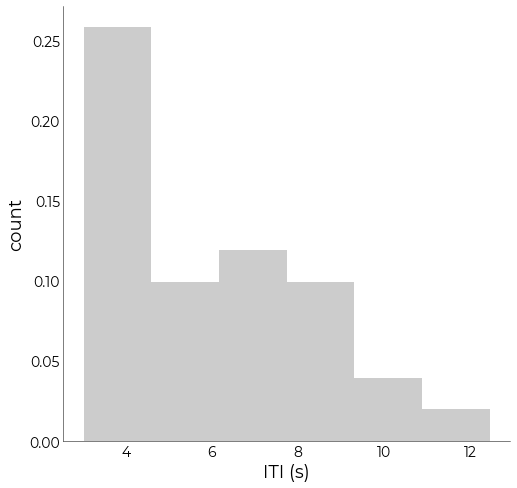

In [42]:
iti_obj.plot_iti_distribution()

In [46]:
# initiate empty design
n_samples = round(iti_obj.total_experiment_time/TR)
dm = np.zeros((*img.shape, n_samples))

iti_obj.get_onsets().tail()

onset  duration
subject run event_type                      
1       1   act         244.968379       2.0
            act         251.934237       2.0
            norm        263.927868       2.0
            norm        270.162360       2.0
            norm        275.182903       2.0

In [49]:
dm = iti_obj.create_prf_design(
    iti_obj,
    stims=stims,
    make_square=True)

dm.shape

(270, 270, 2830)

In [67]:
# initialize object without actual data; mainly insert design matrix
obj_ = prf.pRFmodelFitting(
    None,
    design_matrix=dm,
    TR=TR,
    verbose=True
)

# set position to 0 and parse parameters into array
insert_pars = pars.copy()
for ii in ["x","y"]:
    insert_pars[ii] = 0

l_pars = prf.Parameters(insert_pars, model="norm").to_array()
obj_.load_params(l_pars, model="norm", stage="iter")

Reading settings from '/data1/projects/MicroFunc/Jurjen/programs/packages/linescanning/misc/prf_analysis.yml'
Instantiate HRF with: [1, 1, 0] (fit=False)
Using constraint(s): ['tc', 'tc']
Inserting parameters from <class 'numpy.ndarray'> as 'norm_iter' in <linescanning.prf.pRFmodelFitting object at 0x7f064955cdc0>


Variance = 2.81


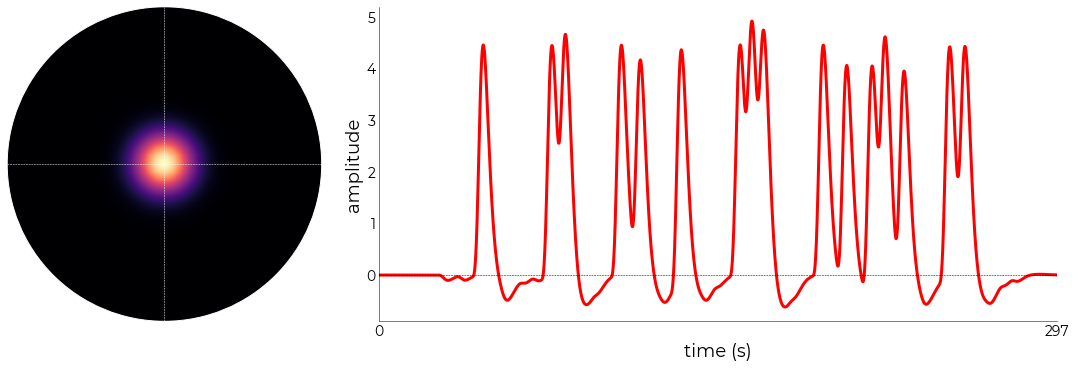

In [70]:
# get timecourse + make plot
_,_,_,tc = obj_.plot_vox(
    vox_nr=0,
    title="pars", 
    model="norm")

# get variance
tc_var = np.var(tc)
print(f"Variance = {round(tc_var,2)}")